# CVAE  (0.3 балла)

Теперь построим CVAE модель. Её отличие в том, что на вход энкодеру и декодеру подаётся значение цифры. Таким образом, модели уже не нужно запоминать значение цифры в латентном коде, т.к. одно добавляется нами вручную.

**Упражнение:** Реализуйте CVAE, модифицировав VAE с использованием полносвязных слоёв, который был разобран в начале семинара. 

Значения лэйблов (y) в виде one-hot векторов нужно присоединить (конкатенировать) к векторам, которые подаются на вход энкодеру и декодеру.

Для получение one-hot векторов используйте функцию F.one_hot(input, n_classes)

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
from ipywidgets import interact
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab as pl
from IPython import display
import numpy as np
from functools import reduce

In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

In [11]:
LOAD_MODEL = False

In [3]:
# MNIST dataset
dataset = torchvision.datasets.MNIST(root='./data_mnist',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [5]:
@interact(i=(0, len(dataset)-1))
def f(i):
    print(dataset[i][1])
    plt.imshow(dataset[i][0].numpy()[0], cmap='gray')

interactive(children=(IntSlider(value=29999, description='i', max=59999), Output()), _dom_classes=('widget-int…

# Создаем модель
# Your code goes here:

In [6]:
# CVAE model
class CVAE(nn.Module):
    def __init__(self, image_size=28, z_size=20):
        super(CVAE, self).__init__()
        self.image_size = image_size * image_size
        self.z_size = 20
        self.class_size = 10

        # encoder
        self.fc1 = nn.Linear(self.image_size + self.class_size, 400)
        self.fc2 = nn.Linear(400, 128)
        self.fc3 = nn.Linear(128, self.z_size)
        self.fc4 = nn.Linear(128, self.z_size)

        # decoder
        self.fc5 = nn.Linear(self.z_size + self.class_size, 400)
        self.fc6 = nn.Linear(400, self.image_size)
        
    def encode(self, x, y):
        x = torch.cat([x, y], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x), self.fc4(x)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z = torch.cat([z, y], 1)
        x = F.relu(self.fc5(z))
        return F.sigmoid(self.fc6(x))
    
    def forward(self, x, y1, y2=None):
        mu, log_var = self.encode(x, y1)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z, y1)
        return x_reconst, mu, log_var

In [7]:
model = CVAE().to(device)

In [8]:
def train(model, data_reader, optimizer, inp_shape=28*28, num_epochs=10):
    # Start training
    loss1 = []
    for epoch in range(num_epochs):
        for i, (x, y) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(inp_shape)
            y = F.one_hot(y, 10).to(device)
            x_reconst, mu, log_var = model(x, y)

            # Compute reconstruction loss and kl divergence
            reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
            kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

            # Backprop and optimize
            loss = reconst_loss + kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                loss1.append(loss.item())
                pl.plot(loss1, color='red')
                display.clear_output(wait=True)
                display.display(pl.gcf())
                print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                      .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item(), kl_div.item()))

Epoch[100/100], Step [1800/1875], Reconst Loss: 2456.4819, KL Div: 618.4364


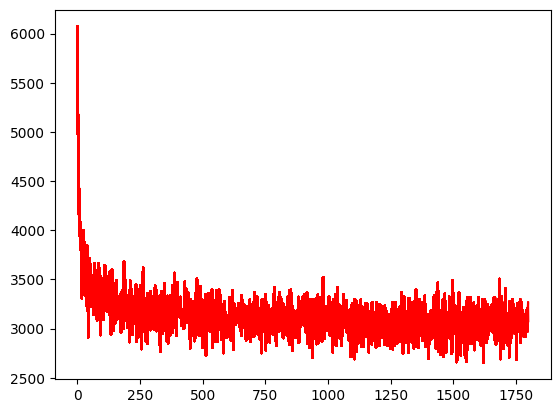

In [9]:
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
train(model, data_loader, optimizer, (-1, 28 * 28), 100)

In [10]:
torch.save(model, './weights_cvae.pth')

In [17]:
# !pip install gdown
!gdown https://drive.google.com/uc?id=1ZKFKGN0oWokuKpDLPbl1JTmPw0qPagl6

Downloading...
From: https://drive.google.com/uc?id=1ZKFKGN0oWokuKpDLPbl1JTmPw0qPagl6
To: /home/testing/pfedotova/hw1/weights_cvae.pth
100%|██████████████████████████████████████| 2.81M/2.81M [00:00<00:00, 7.36MB/s]


In [ ]:
if LOAD_MODEL:
    model = torch.load('weights_cvae.pth')

In [14]:
model.to('cpu')

CVAE(
  (fc1): Linear(in_features=794, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=20, bias=True)
  (fc4): Linear(in_features=128, out_features=20, bias=True)
  (fc5): Linear(in_features=30, out_features=400, bias=True)
  (fc6): Linear(in_features=400, out_features=784, bias=True)
)

In [15]:
n = 10
im_size = 28
from scipy.stats import norm
# Так как сэмплируем из N(0, I), то сетку узлов, в которых генерируем цифры, берем из обратной функции распределения
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, lbl, show=True, device='cpu'):
    with torch.no_grad():
        # Рисование цифр из многообразия
        figure = np.zeros((im_size * n, im_size * n))
        input_lbl = np.zeros((1, 10))
        input_lbl[0, lbl] = 1
        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                z_sample = np.zeros((1, 20))
                z_sample[:, :2] = np.array([[xi, yi]])
                z_sample = torch.tensor(z_sample, dtype=torch.float).to(device)
                input_lbl = torch.tensor(input_lbl, dtype=torch.float).to(device)
                # print(f'z_sample shape: {z_sample.shape}')
                # print(f'torch tensor shape: {torch.tensor(lbl).view(-1, 1).shape}')
                # print(f'x decoded shape: {model.decode(z_sample, torch.tensor(lbl).view(-1, 1)).cpu().numpy()}')
                x_decoded = model.decode(z_sample, input_lbl).cpu().detach().numpy().reshape((im_size, im_size))
                digit = x_decoded.squeeze() 
                figure[i * im_size: (i + 1) * im_size,
                    j * im_size: (j + 1) * im_size] = digit
        if show:
            # Визуализация
            plt.figure(figsize=(10, 10))
            plt.imshow(figure, cmap='gray')
            plt.grid(False)
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            plt.show()
    return figure

/home/testing/pfedotova/cuda/lib/python3.8/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/tmp/ipykernel_22180/1621987000.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_lbl = torch.tensor(input_lbl, dtype=torch.float).to(device)


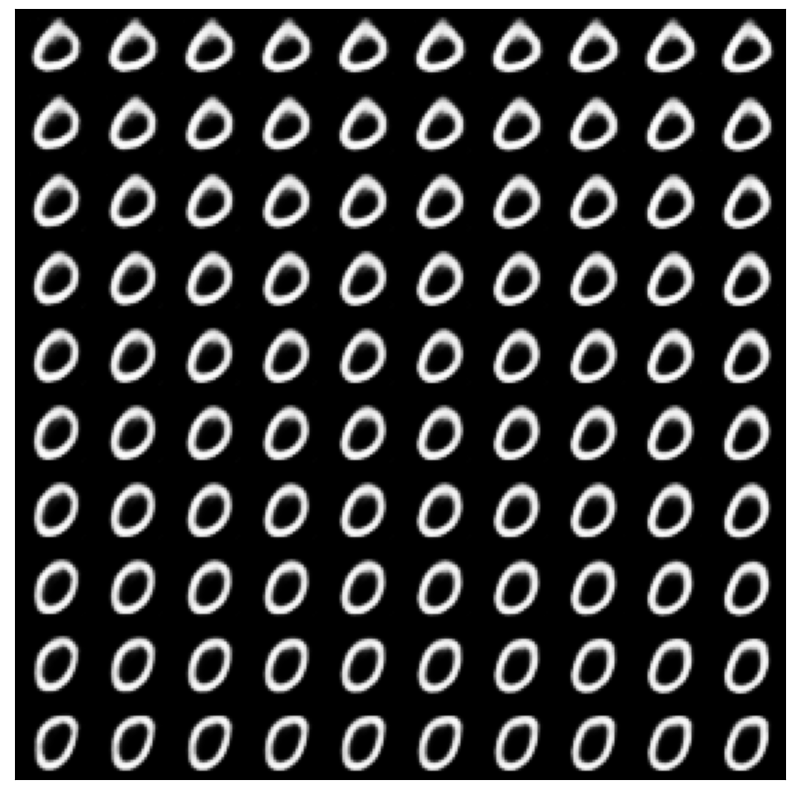

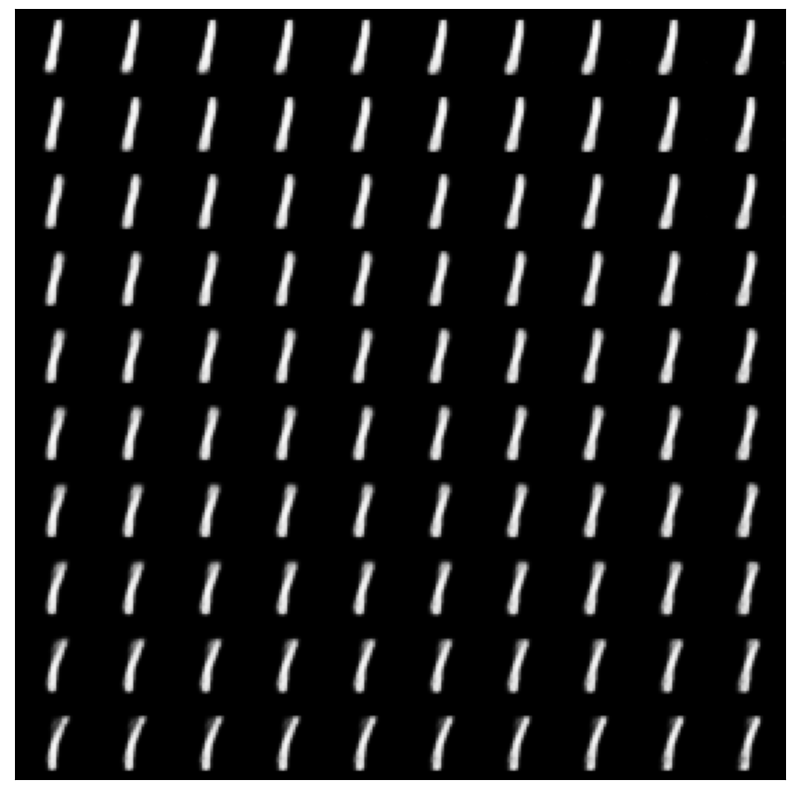

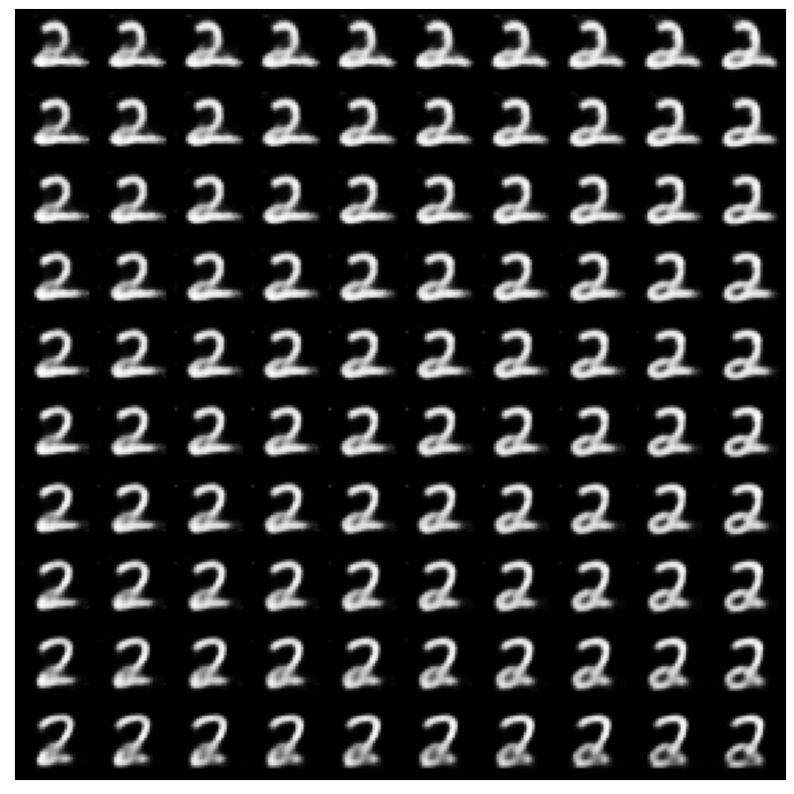

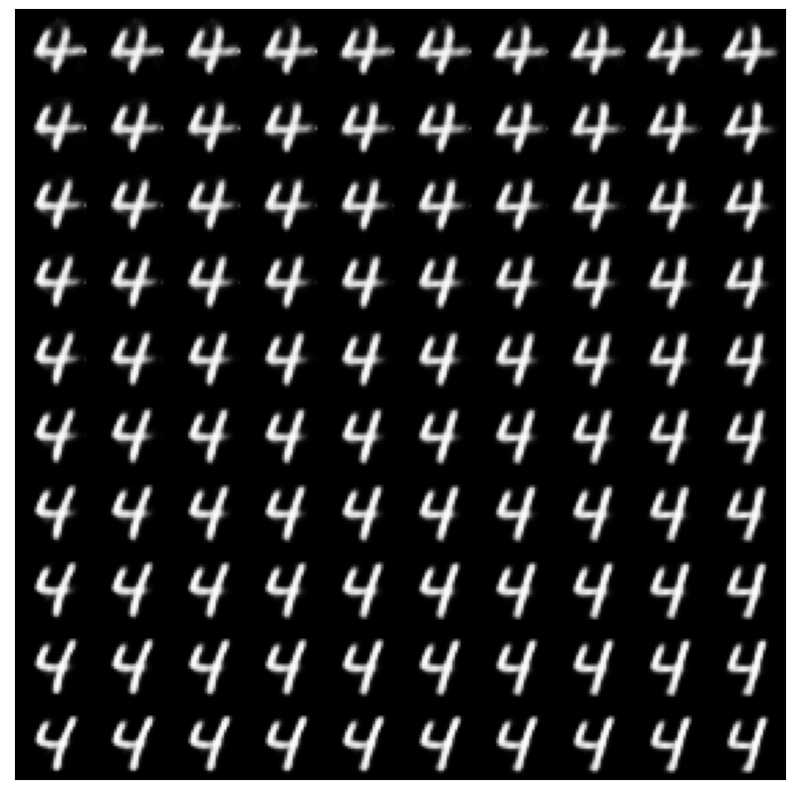

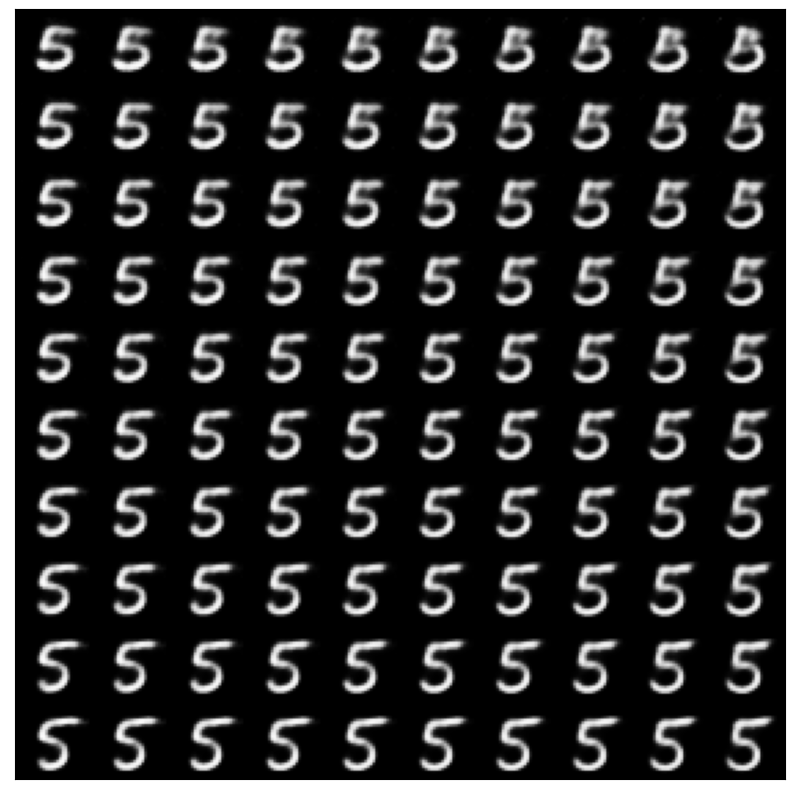

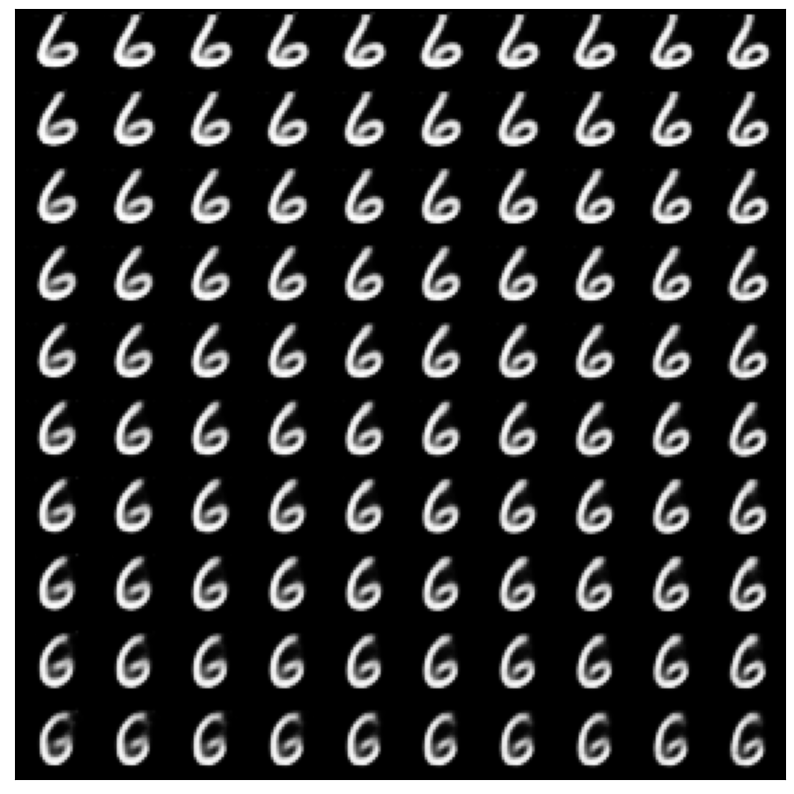

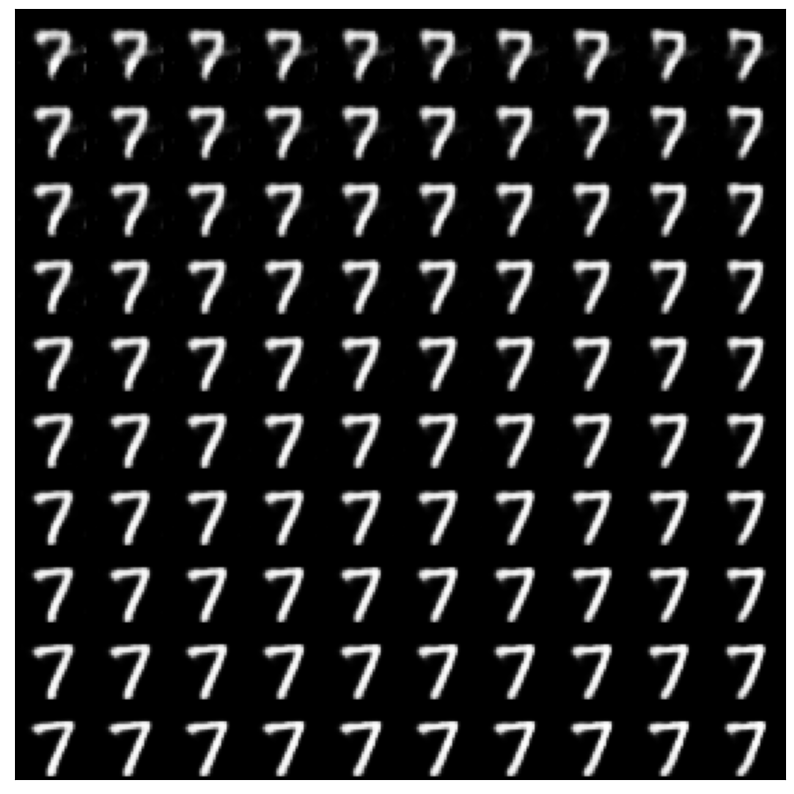

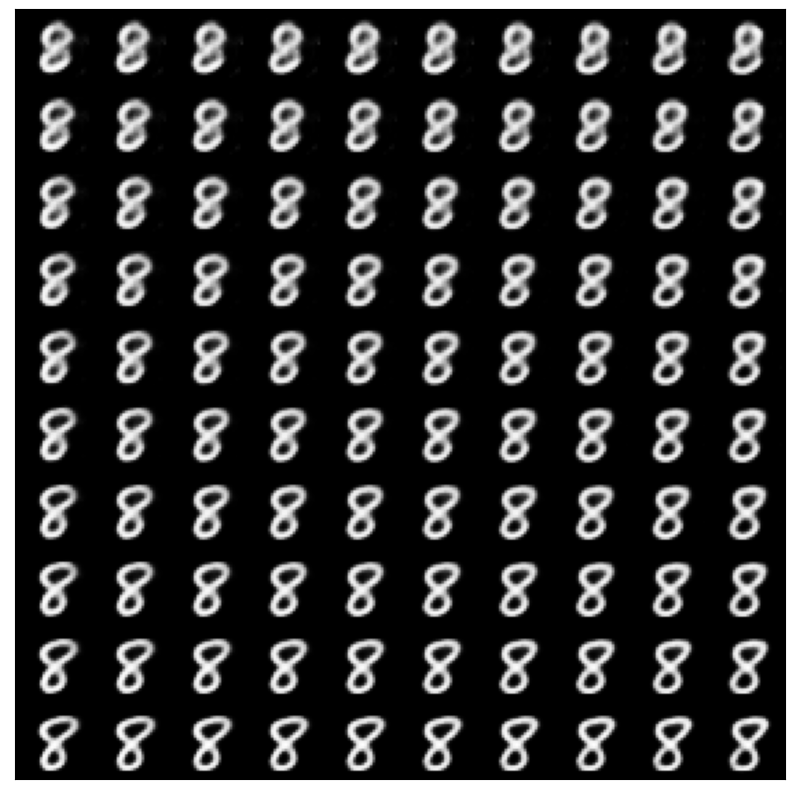

In [16]:
for i in range(10):
    draw_manifold(model, i)